# Conllu files exploration for Cleanup Memory insertion

The idea of this notebook is to explore the CONLLU files to extract the knowledge and be able to create compressed memories indexed with similarity search (or Locallity Sensitive Hashing).

The final goal is to be able to insert that knowledge directly inside a memory in a neural network such as the learning happens as a mapping from the input to the cleanup memory that can have new knowledge added from an external source directly in the memory leading to my idea of the NeuralDB

### EU Official Languages

The European Union has 23 official languages:

Bulgarian, Czech, Danish, Dutch, English, Estonian, Finnish, French, German, Greek, Hungarian, Irish, Italian, Latvian, Lithuanian, Maltese, Polish, Portuguese, Romanian, Slovak, Slovenia, Slovene, Spanish and Swedish.

In [7]:
cd ../

/home/leo/projects/mix_nlp/utf8


In [9]:
from multiprocessing import Pool, cpu_count

import math
import os, sys
import orjson as json
import pyconll
import pyconll.util

try:
    from utf8.utils import *
except:
    # to solve issue with ipython executing this import
    from utils import *

from preprocessors.preprocess_conllu import *

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [11]:
UD_VERSION = "2.5"
BASEPATH = "/home/leo/projects/Datasets/text"
CONLLU_BASEPATH = os.path.join(BASEPATH, 'UniversalDependencies/ud-treebanks-v{}'.format(UD_VERSION))

In [12]:
rootdir=CONLLU_BASEPATH
blacklist=BLACKLIST
allconll = get_all_files_recurse(rootdir)
train, test, dev = filter_conllu_files(allconll, blacklist)

In [13]:
len(test)

91

In [14]:
test_fr = [f for f in test if "French" in f]

In [15]:
test_fr

['/home/leo/projects/Datasets/text/UniversalDependencies/ud-treebanks-v2.5/UD_French-Spoken/fr_spoken-ud-test.conllu',
 '/home/leo/projects/Datasets/text/UniversalDependencies/ud-treebanks-v2.5/UD_French-Sequoia/fr_sequoia-ud-test.conllu',
 '/home/leo/projects/Datasets/text/UniversalDependencies/ud-treebanks-v2.5/UD_French-GSD/fr_gsd-ud-test.conllu',
 '/home/leo/projects/Datasets/text/UniversalDependencies/ud-treebanks-v2.5/UD_French-PUD/fr_pud-ud-test.conllu',
 '/home/leo/projects/Datasets/text/UniversalDependencies/ud-treebanks-v2.5/UD_French-ParTUT/fr_partut-ud-test.conllu',
 '/home/leo/projects/Datasets/text/UniversalDependencies/ud-treebanks-v2.5/UD_French-FQB/fr_fqb-ud-test.conllu',
 '/home/leo/projects/Datasets/text/UniversalDependencies/ud-treebanks-v2.5/UD_Old_French-SRCMF/fro_srcmf-ud-test.conllu']

In [16]:
fname = test_fr[5]
conll = pyconll.load_from_file(fname)

In [17]:
sentences = [s for s in conll]

In [18]:
len(sentences)

2289

In [19]:
len(conll)

2289

In [20]:
[t.form for t in sentences[0]._tokens]

["Qu'", 'est', '-ce', "qu'", 'une', 'aide', 'au', 'à', 'le', 'logement', '?']

Now I'll analyze the sets of knowledge extracted from the conllu files, the idea is to try to compress all the knowledge and later be able to match the sentences with the right knowledge status.

One of the ways of doing this is having a key-value memory, where the key is looked at by similarity search and the output value is a weighted sum of the *top k* values

A simple analysis of the fields gives a first approach on what to add as knowledge

    conll_lemma.append([t.lemma for t in sen._tokens])  # this one doesn't work for multi-lang .. better for mono-lang, also needs really big dataset, this kind of knowledge can be obtained form a dictionary
    conll_upos.append([t.upos for t in sen._tokens]) #this one
    conll_xpos.append([t.xpos for t in sen._tokens]) #this one
    conll_feats.append([t.head for t in sen._tokens]) # difficult to do a first target memory, is a complex field 
    conll_head.append([t.deprel for t in sen._tokens]) #this one
    sen_form = [t.form for t in sen._tokens]  # difficult to do a first target memory, is a complex field
    sen_feats = [t.feats for t in sen._tokens]  # difficult to do a first target memory, is a complex field
    sen_deps = [t.deps for t in sen._tokens]  # TOO complex
    sen_misc = [t.mis for t in sen._tokens]  # TOO complex



In [21]:
# def _try_process_2list(fname):
#     try:
#         return conllu_separate_fields(fname)
#     except Exception as e:
#         print("Error processing file: {} \nWith error: {}".format(fname, e))


# def conllu_process_2list(rootdir=CONLLU_BASEPATH, blacklist=BLACKLIST):
#     allconll = get_all_files_recurse(rootdir)
#     train, test, dev = filter_conllu_files(allconll, blacklist)
#     all_files = train + test + dev
#     # print(all_files)

#     with Pool(processes=cpu_count()) as pool:
#         res = pool.map(_try_process_2list, all_files)
#         return res

In [22]:
# res = conllu_separate_fields(test_fr[0])

In [23]:
# res

In [24]:
# %%time
# res = conllu_process_2list()

In [25]:
# len(res)

In [26]:
# res = [r for r in res if r[0][1] > 0]

In [27]:
# len(res)

In [28]:

def conllu_get_fields(fname):
    """
    Processes one conllu file
    :param fname: absolute path to the conllu file
    :return:
    """
    conll = pyconll.load_from_file(fname)
    upos = []
    xpos = []
    deprel = []
    sentences = []
    forms = []

    src_lang = path_leaf(fname).split('_')[0]
    for sen in conll:
        sentences.append((src_lang, sen.text))
        try:
            forms.extend([t.form for t in sen._tokens])
        except:
            pass
        try:
            sen_upos = [t.upos for t in sen._tokens]
            upos.append((src_lang, sen.text, tuple(sen_upos)))
        except:
            pass
        try:
            sen_xpos = [t.xpos for t in sen._tokens]
            xpos.append((src_lang, sen.text, tuple(sen_xpos)))
        except:
            pass
        try:
            sen_deprel = [t.deprel for t in sen._tokens]
            deprel.append((src_lang, sen.text, tuple(sen_deprel)))
        except:
            pass
    
    return (set(upos), len(upos)), (set(xpos), len(xpos)), (set(deprel), len(deprel)), (set(sentences), len(sentences)), (set(forms), len(forms))


In [29]:
(upos, upos_count), (xpos, xpos_count), (deprel, deprel_count), (sentences, sentences_count), (forms, forms_count) = conllu_get_fields(test_fr[0])

In [30]:
len(upos), upos_count, len(xpos), xpos_count, len(deprel), deprel_count, len(sentences), sentences_count

(719, 726, 719, 726, 720, 726, 719, 726)

In [31]:

def _try_get_2list(fname):
    try:
        return conllu_get_fields(fname)
    except Exception as e:
        print("Error processing file: {} \nWith error: {}".format(fname, e))


def conllu_process_get_2list(rootdir=CONLLU_BASEPATH, blacklist=BLACKLIST):
    allconll = get_all_files_recurse(rootdir)
    train, test, dev = filter_conllu_files(allconll, blacklist)
    all_files = train + test + dev
    # print(all_files)

    with Pool(processes=cpu_count()) as pool:
        res = pool.map(_try_get_2list, all_files)
        return res


In [32]:
%%time
res = conllu_process_get_2list()

CPU times: user 7.87 s, sys: 1.88 s, total: 9.76 s
Wall time: 1min 18s


In [33]:
len(res), len(res[0])

(231, 5)

In [34]:
(upos, upos_count), (xpos, xpos_count), (deprel, deprel_count), (sentences, sentences_count), (forms, forms_count) = res[20]

In [35]:
# list(upos)[0]

In [36]:
len(upos), upos_count, len(xpos), xpos_count, len(deprel), deprel_count, len(sentences), sentences_count, len(forms), forms_count

(319, 319, 319, 319, 319, 319, 319, 319, 2834, 6383)

XPOS seems to be always None!!! :S -> check what happens there ... but for the moment I don  care as there are other things to see ...

Finding now the shortest and longest sequences, checking the length and plotting those to see what's happening with the dataset.

In [37]:
%%time

upos_data = []
xpos_data = []
deprel_data = []
sentences_data = []
forms_data = []

for r in res:
    upos_val, xpos_val, deprel_val, sentences_val, forms_val = r
#     print("lala 1")
    forms_data.extend(forms_val[0])
    for val in upos_val[0]:
#         print(val)
        lang1, txt1, upos  = val
        upos_data.append((lang1, txt1, upos, len(upos)))
    for lang2, txt2, xpos in xpos_val[0]:
        xpos_data.append((lang2, txt2, xpos, len(xpos)))
    for lang3, txt3, deprel in deprel_val[0]:
        deprel_data.append((lang3, txt3, deprel, len(deprel)))
    for lang4, txt4 in sentences_val[0]:
        sentences_data.append((lang4, txt4, len(txt4)))

# upos_data = sorted(upos_data)
# xpos_data = sorted(xpos_data)
# deprel_data = sorted(deprel_data)

    

CPU times: user 1.34 s, sys: 82.5 ms, total: 1.42 s
Wall time: 1.43 s


In [38]:
len(upos_data), len(xpos_data), len(deprel_data), len(forms_data)

(979186, 979384, 979474, 2857622)

In [39]:
# sorted(forms_data)

In [40]:
df_upos = pd.DataFrame(upos_data, columns=["lang", "text", "upos", "upos_len"])
df_xpos = pd.DataFrame(xpos_data, columns=["lang", "text", "xpos", "xpos_len"])
df_deprel = pd.DataFrame(deprel_data, columns=["lang", "text", "deprel", "deprel_len"])
df_txt = pd.DataFrame(sentences_data, columns=["lang", "text", "text_len"])

In [41]:
df_upos.columns

Index(['lang', 'text', 'upos', 'upos_len'], dtype='object')

In [42]:
df_upos['lang'].describe

<bound method NDFrame.describe of 0         eu
1         eu
2         eu
3         eu
4         eu
          ..
979181    nl
979182    nl
979183    nl
979184    nl
979185    nl
Name: lang, Length: 979186, dtype: object>

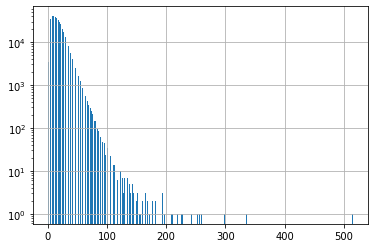

In [43]:
# fig, ax = plt.subplots()
# series.hist(ax=ax, bins=100, bottom=0.1)
# ax.set_yscale('log')
df_upos['upos_len'].hist(bins=1000, log=True)

First exploration seems to show a difference of sentence length by groups, which might be due to languages ... so I'll try to see what are the  issues and then I'll select languages and lengths accordingly



In [44]:
langs = sorted(df_upos['lang'].unique())

In [45]:
from pycountry import languages


In [46]:
df_upos.describe()

,upos_len
count,979186.000000
mean,18.158833
std,12.451608
min,1.000000
25%,9.000000
50%,16.000000
75%,24.000000
max,515.000000


<ipython-input-47-ecce23c2749e>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


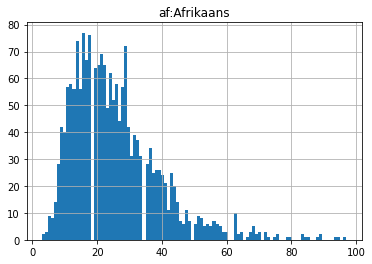

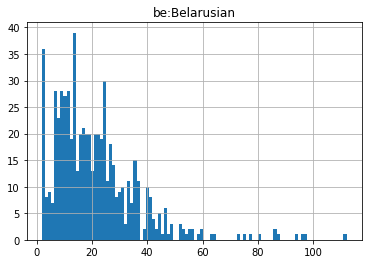

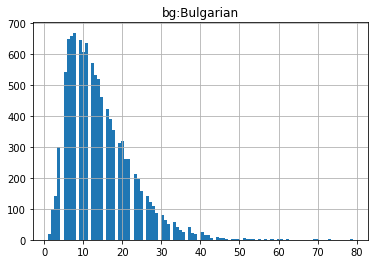

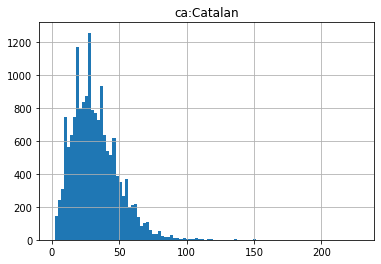

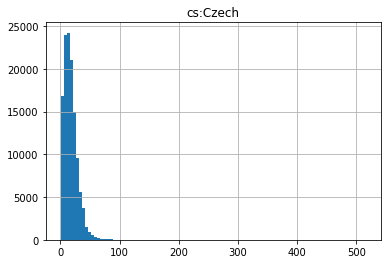

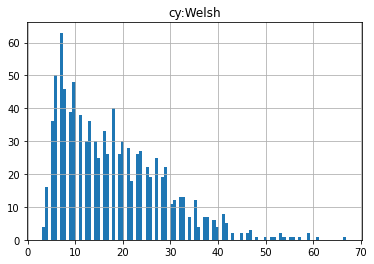

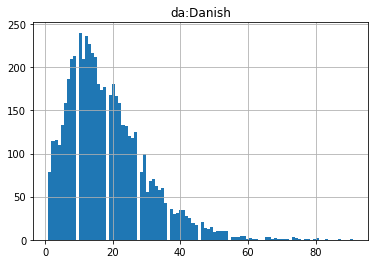

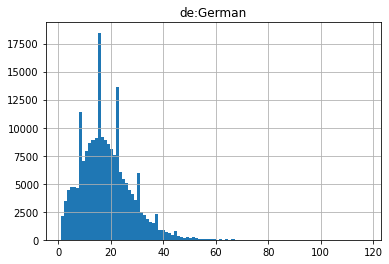

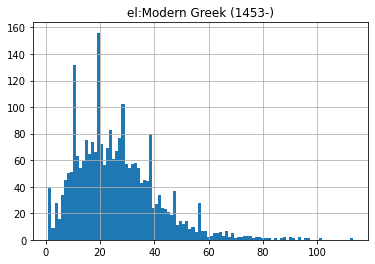

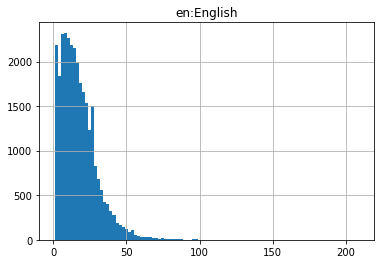

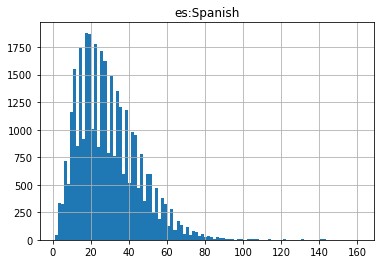

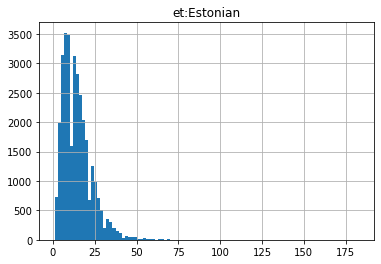

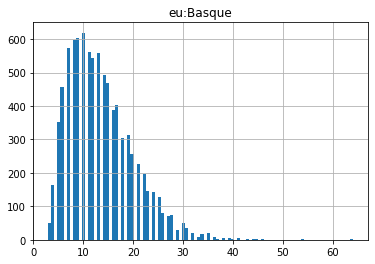

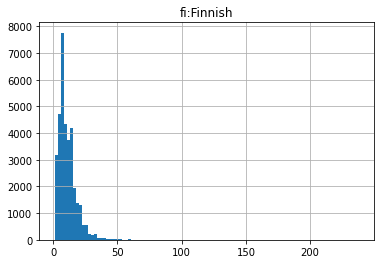

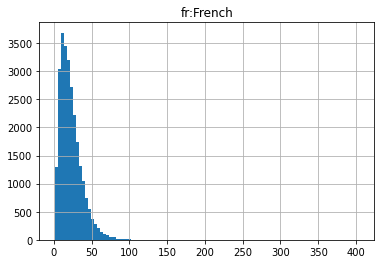

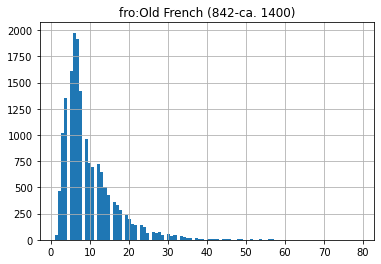

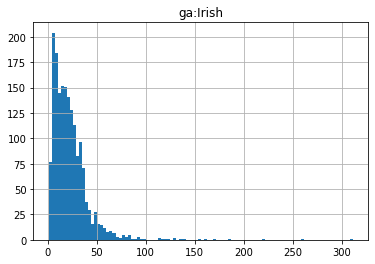

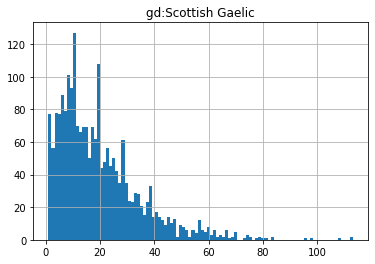

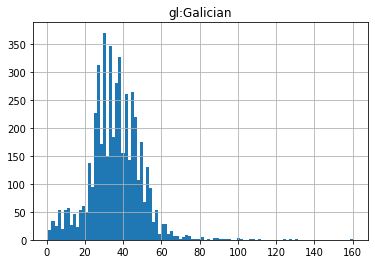

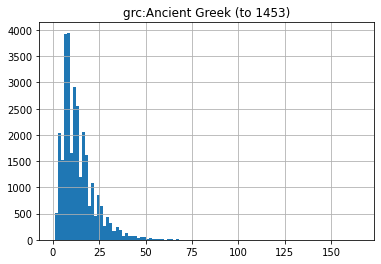

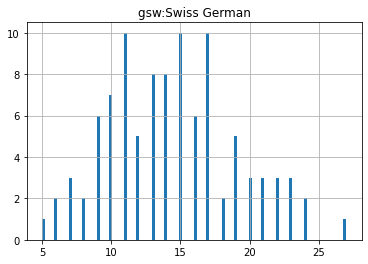

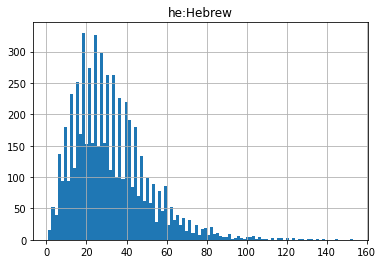

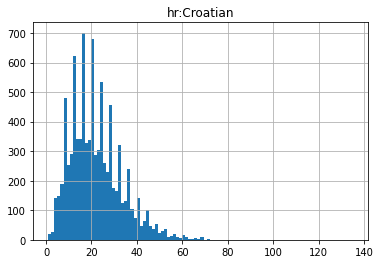

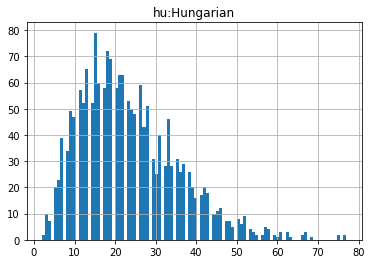

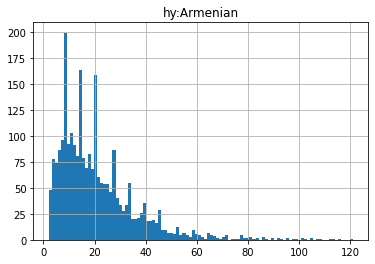

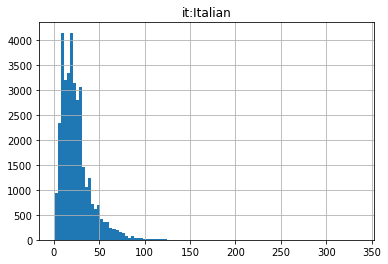

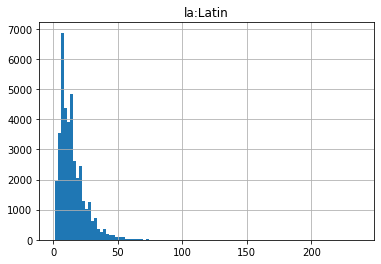

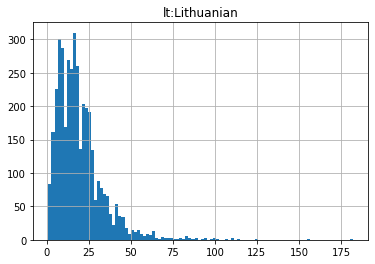

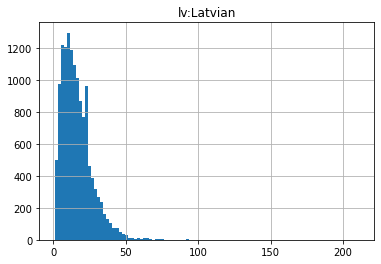

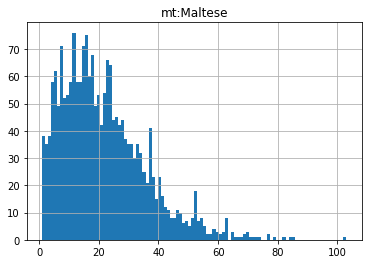

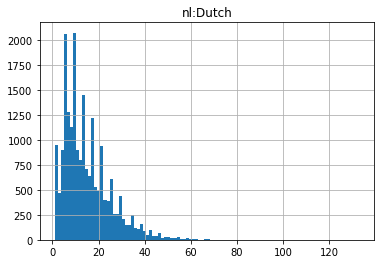

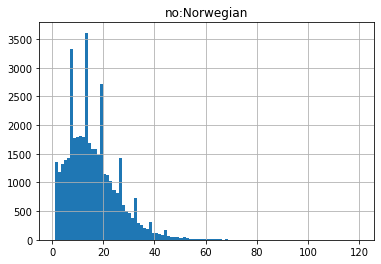

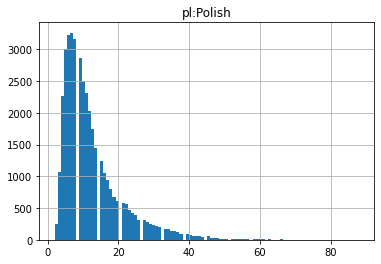

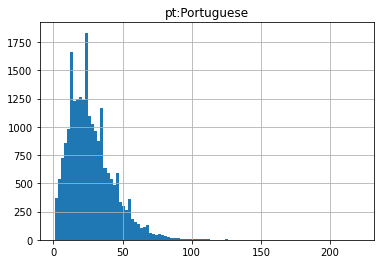

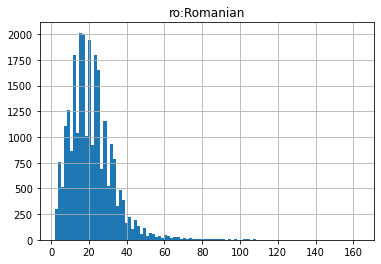

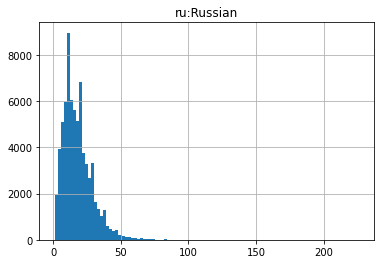

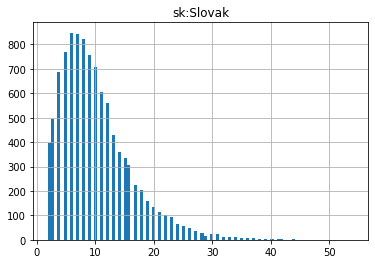

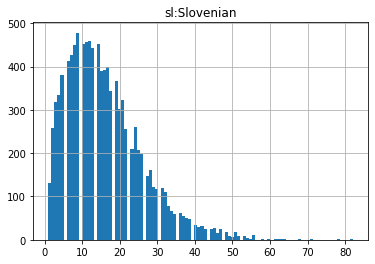

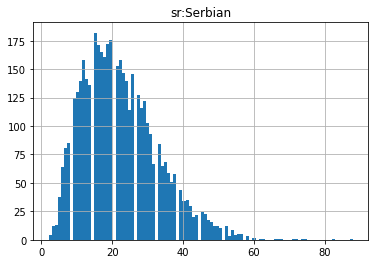

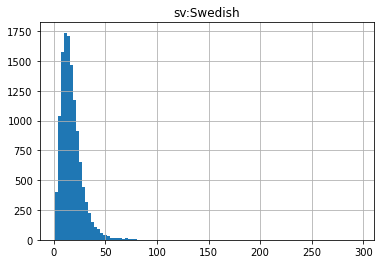

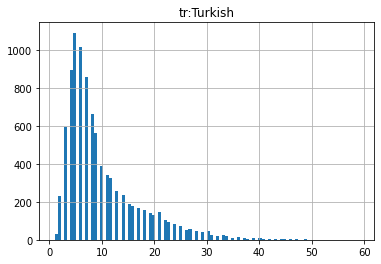

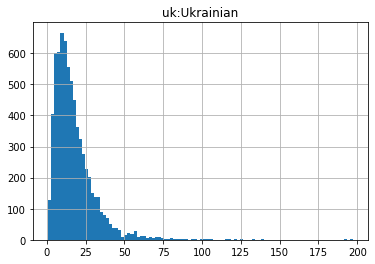

In [47]:
for lang in langs:
    fig, ax = plt.subplots()
    dest_lang = languages.get(alpha_2=lang) if len(lang) == 2 else languages.get(alpha_3=lang)
    dest_lang = dest_lang.name
    ax.set_title(lang +":" +dest_lang )
    df_upos.loc[df_upos['lang'] == lang]['upos_len'].hist(bins=100, ax=ax, label=lang)

In [48]:
len(langs), langs

(42,
 ['af',
  'be',
  'bg',
  'ca',
  'cs',
  'cy',
  'da',
  'de',
  'el',
  'en',
  'es',
  'et',
  'eu',
  'fi',
  'fr',
  'fro',
  'ga',
  'gd',
  'gl',
  'grc',
  'gsw',
  'he',
  'hr',
  'hu',
  'hy',
  'it',
  'la',
  'lt',
  'lv',
  'mt',
  'nl',
  'no',
  'pl',
  'pt',
  'ro',
  'ru',
  'sk',
  'sl',
  'sr',
  'sv',
  'tr',
  'uk'])

A token is a word or a punctuation mark. Punctuation is counted in the sentence length.

Is interesting to see that most languages have few sentences longer than 100 tokens (including the punctuation)

Also, each language has a different centroid for the sentence length.

Also it's an interesting that different languages show different strip patterns, each having a different interval of lengths that are empty (like basque for example) while the count next to it has high counts (length 10 for basque has a count of more than 600 while the left and right are just empty). 

These patterns are really interesting.



In [49]:
df_deprel.describe()

,deprel_len
count,979474.000000
mean,18.158577
std,12.451090
min,1.000000
25%,9.000000
50%,16.000000
75%,24.000000
max,515.000000


<ipython-input-50-82578aad61cd>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


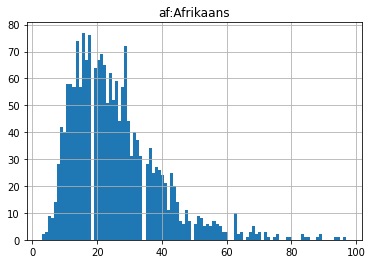

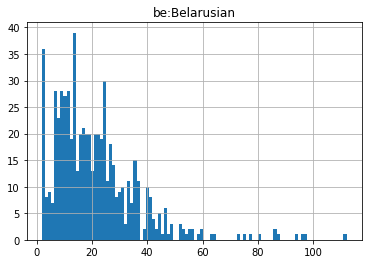

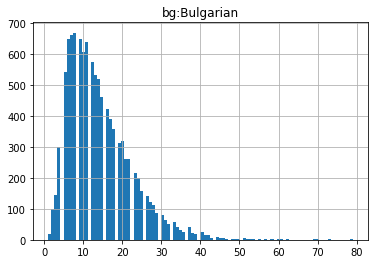

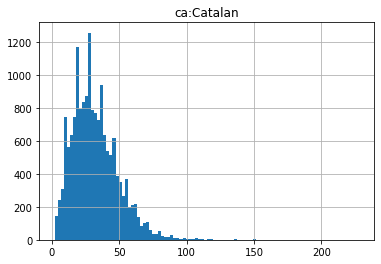

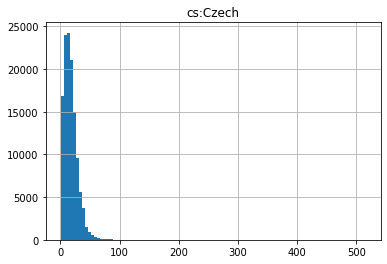

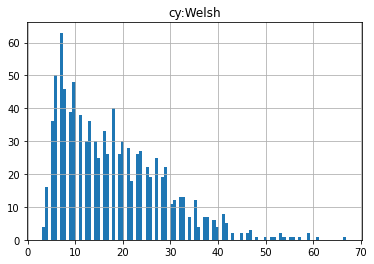

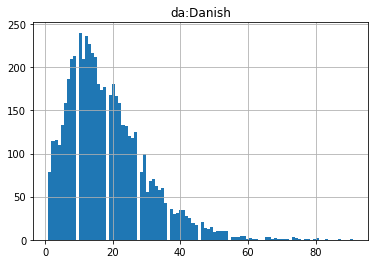

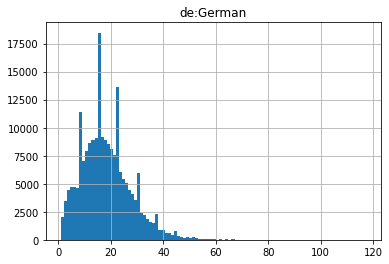

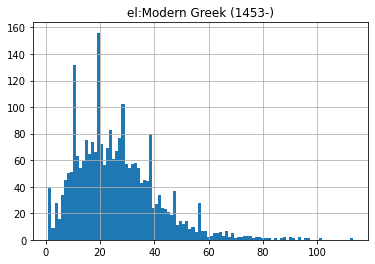

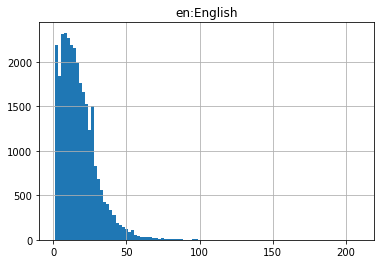

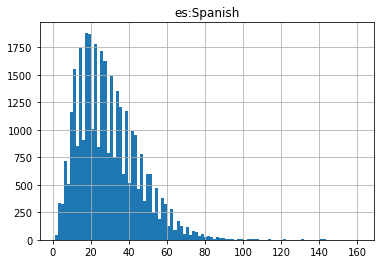

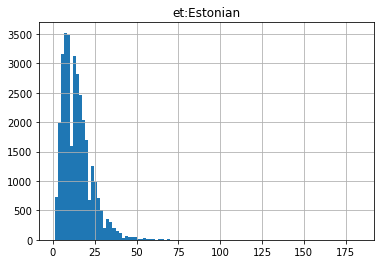

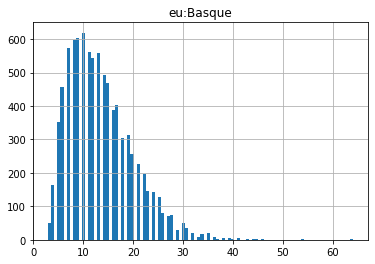

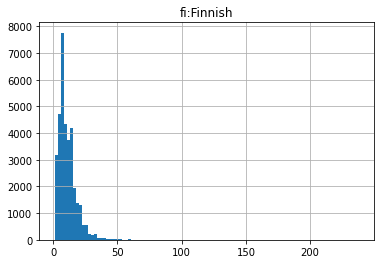

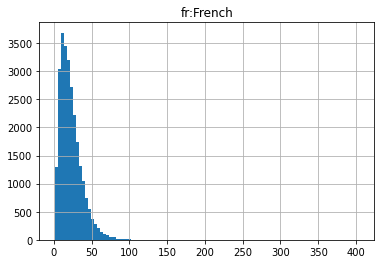

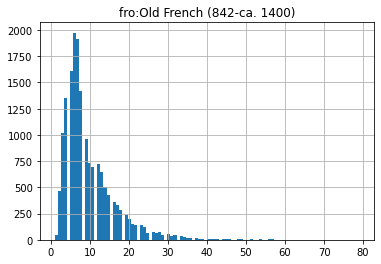

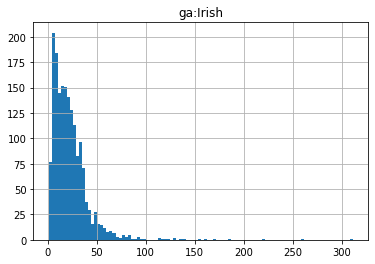

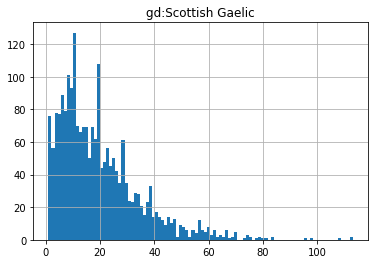

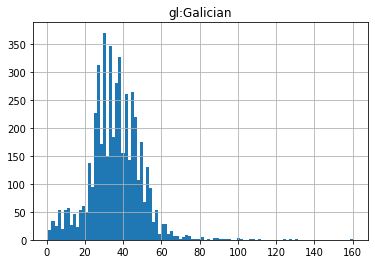

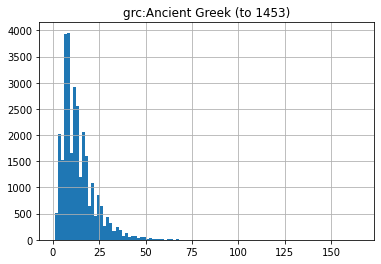

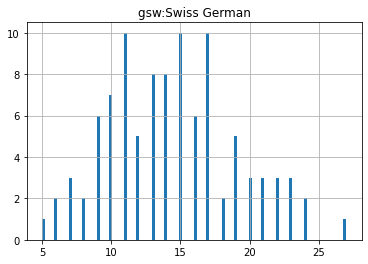

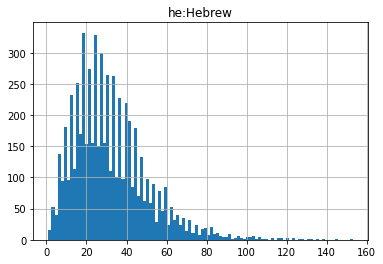

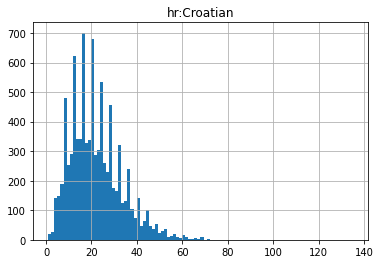

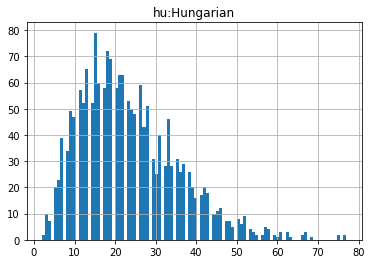

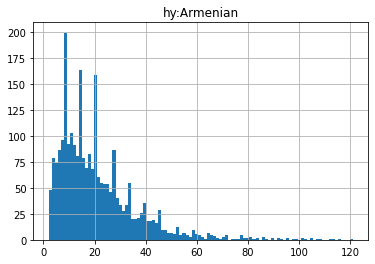

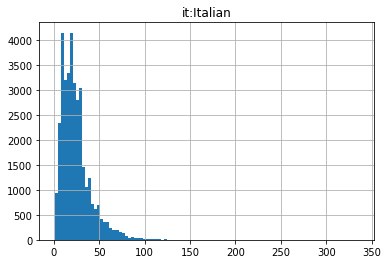

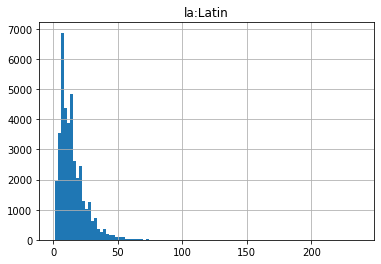

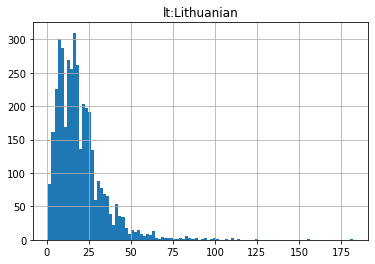

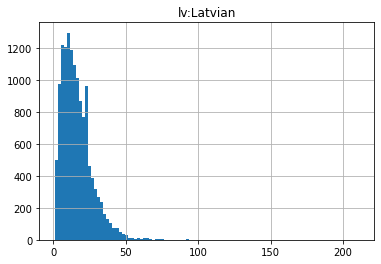

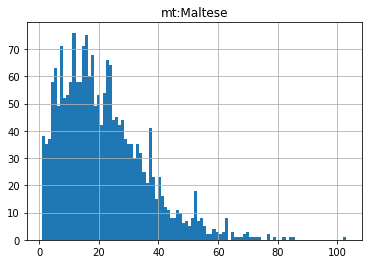

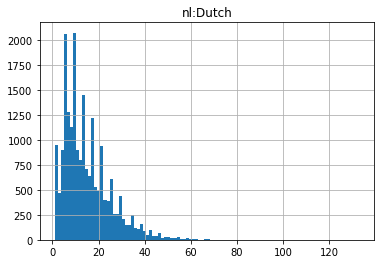

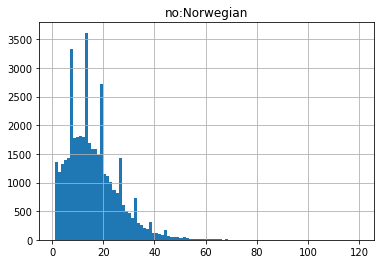

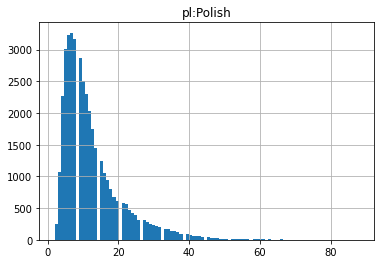

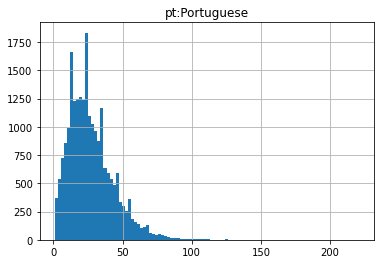

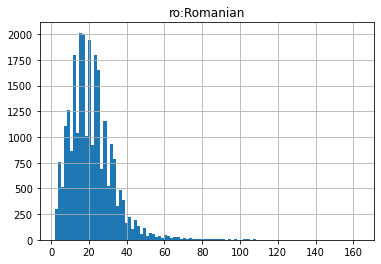

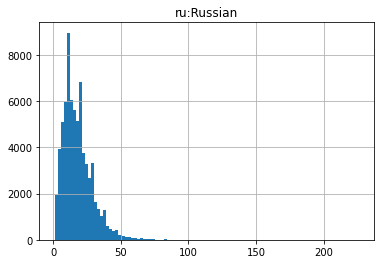

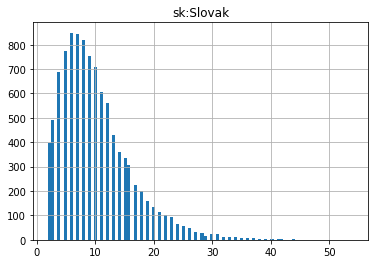

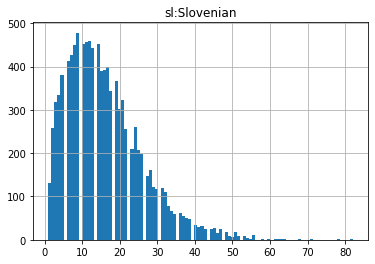

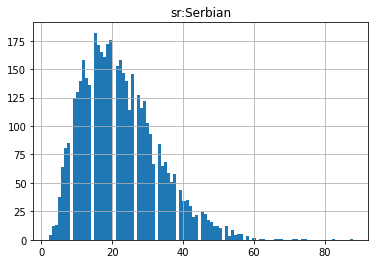

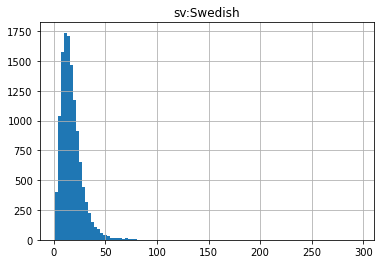

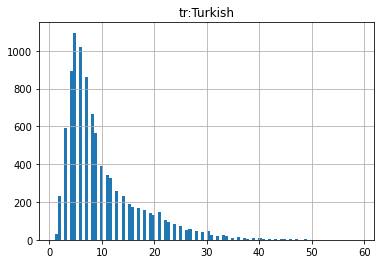

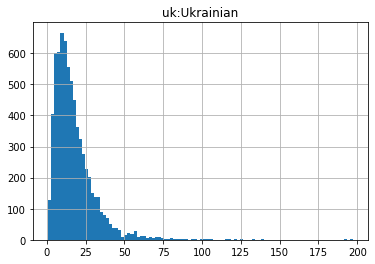

In [50]:
for lang in langs:
    fig, ax = plt.subplots()
    dest_lang = languages.get(alpha_2=lang) if len(lang) == 2 else languages.get(alpha_3=lang)
    dest_lang = dest_lang.name
    ax.set_title(lang +":" +dest_lang )
    df_deprel.loc[df_deprel['lang'] == lang]['deprel_len'].hist(bins=100, ax=ax, label=lang)

In [51]:
df_txt.describe()

,text_len
count,978880.000000
mean,102.846980
std,70.134943
min,1.000000
25%,51.000000
50%,90.000000
75%,138.000000
max,3471.000000


Checking the values we can see, even though we have a  max of 3471 characters, if we want to see how much of the spectrum we capture is as follows (if it were a normal distribution which I don't want to test but it should work well enough):

| char_len | mean+X*std | % captured |
|:--------:|:----------:|:----------:|
|    90    |            |     50%    |
|    138   |            |     75%    |
|    173   |  103+1*70  |    84.2%   |
|    243   |  103+2*70  |    98.8%   |
|    313   |  103+3*70  |    99.9%   |

So going for a maximum sequence length of at least 313 should capture most of the sequences in the training and testing datasets (and as they should also be significant of each language ... it should be enough), now this analysis should be done by language instead, and then really choose according to the results in each.

In [52]:

len_lang_list = []

_99p = []
_98p = []
_84p = []

for lang in langs:
    dest_lang = languages.get(alpha_2=lang) if len(lang) == 2 else languages.get(alpha_3=lang)
    dest_lang = dest_lang.name
    lng_txt = df_txt.loc[df_txt['lang'] == lang]
    d = lng_txt.describe()
    mean = d.loc['mean']['text_len']
    std = d.loc['std']['text_len']
    ef,ne,nn = math.ceil(mean+std), math.ceil(mean+2*std), math.ceil(mean+3*std)
    _99p.append(nn)
    _98p.append(ne)
    _84p.append(ef)
    len_lang_list.append((lang, dest_lang, ef, ne, nn))
    print(dest_lang)
    print("""
            |    {}   |  84.2%   |
            |    {}   |  98.8%   |
            |    {}   |  99.9%   |""".format(ef, ne, nn)
    )
    print(lng_txt.describe())
    print("_"*50)
#     lng_txt.describe()

Afrikaans

            |    230   |  84.2%   |
            |    310   |  98.8%   |
            |    390   |  99.9%   |
          text_len
count  1899.000000
mean    149.538705
std      79.961305
min      20.000000
25%      93.000000
50%     133.000000
75%     188.000000
max     566.000000
__________________________________________________
Belarusian

            |    245   |  84.2%   |
            |    354   |  98.8%   |
            |    463   |  99.9%   |
         text_len
count  633.000000
mean   136.124803
std    108.714883
min      7.000000
25%     65.000000
50%    110.000000
75%    182.000000
max    851.000000
__________________________________________________
Bulgarian

            |    126   |  84.2%   |
            |    174   |  98.8%   |
            |    223   |  99.9%   |
           text_len
count  10969.000000
mean      76.594858
std       48.638239
min        2.000000
25%       40.000000
50%       67.000000
75%      103.000000
max      458.000000
___________________________

In [53]:
max(_99p), max(_98p), max(_84p)

(463, 354, 253)

When checking individually each language, the maximum length would be much higher, this is because some languages contain longer sentences, so we have to deal with this selecting a bigger sentence length to be able to capture most of it.

The longest being Belarusian, checking that has cyrillic alphabet and we are thinking of using or not this script, we can take this language out too.

The complete list is sorted and printed here:

In [54]:
list(reversed(sorted(len_lang_list, key=lambda x: x[4])))

[('be', 'Belarusian', 245, 354, 463),
 ('ga', 'Irish', 225, 334, 444),
 ('ca', 'Catalan', 253, 341, 430),
 ('hy', 'Armenian', 221, 321, 420),
 ('es', 'Spanish', 238, 324, 410),
 ('el', 'Modern Greek (1453-)', 235, 322, 410),
 ('lt', 'Lithuanian', 214, 306, 398),
 ('hu', 'Hungarian', 232, 313, 394),
 ('af', 'Afrikaans', 230, 310, 390),
 ('it', 'Italian', 202, 284, 366),
 ('gl', 'Galician', 231, 293, 354),
 ('pt', 'Portuguese', 199, 274, 349),
 ('mt', 'Maltese', 193, 270, 348),
 ('uk', 'Ukrainian', 177, 258, 339),
 ('hr', 'Croatian', 199, 268, 338),
 ('fr', 'French', 187, 262, 337),
 ('gd', 'Scottish Gaelic', 178, 256, 335),
 ('sr', 'Serbian', 192, 256, 320),
 ('cs', 'Czech', 173, 246, 318),
 ('ru', 'Russian', 173, 242, 310),
 ('de', 'German', 183, 246, 309),
 ('ro', 'Romanian', 172, 236, 300),
 ('lv', 'Latvian', 162, 229, 297),
 ('da', 'Danish', 162, 228, 293),
 ('sv', 'Swedish', 157, 220, 282),
 ('en', 'English', 151, 216, 280),
 ('la', 'Latin', 152, 215, 279),
 ('et', 'Estonian', 151,

The languages with the longest sentences can be handled in a couple of ways:
1. either be taken out
2. deal with a larget loss on train/test dataset coverage

Belarusian, Irish, Catalan and Armenian can be taken out of the dataset if we think about training complexity and that they don't belong to either the EU or a language with a major number of speakers (for the purpose of this study, although I'd like to use them all)
Afrikaans can also be taken out.

The issue is with Spanish (which is an EU language and widely spolen around the globe), Lithuanian, Hungarian, Afrikaans and Modern Greek (that comes from ancient greek and has a major influence in other languages)

For the case of the Greek language either we can take it out simplifying the character basis for the compositional algorithm or we can deal with a bigger loss than 0.1%

For the cases of Spanish Lithuanian and Hungarian language the decision gets a bit more complex as is in the EU language list that I'd like to deal with.


Also, to reduce complexity of the neural networks and training I can choose to have a basic building block for the compositional encoding while NOT using greek and cyrillic alphabets (and the languages that use them), this could be a good enough compromise as the characters are present if I want to evolve the codebook but don't take too much space in it. Although for a one-hot decoding this DOES have a performance impact.

___

___Note to self:___ Here is where I might want to start working with a more complex tokenization (like n-grams)


In [55]:
d = lng_txt.describe()

In [56]:
d.loc['mean']['text_len']

95.62113402061856

In [57]:
d.index

Index(['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], dtype='object')

<ipython-input-58-f5c17ff5e2b9>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


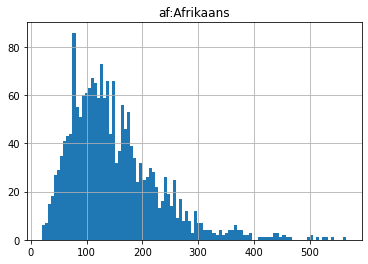

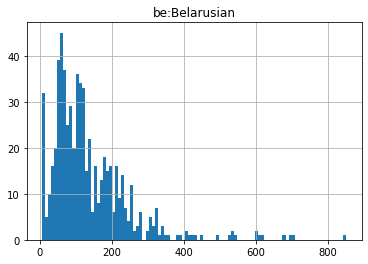

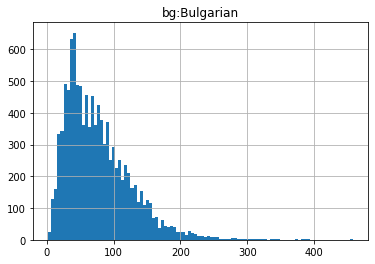

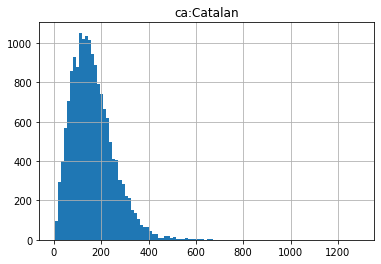

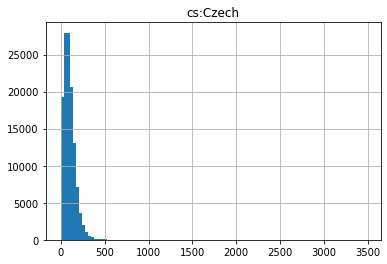

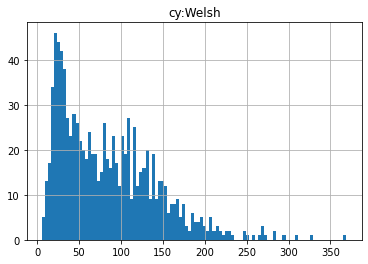

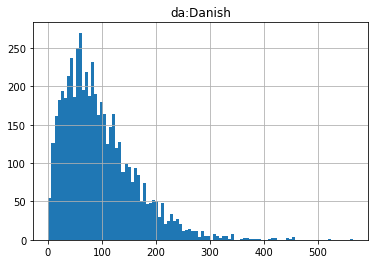

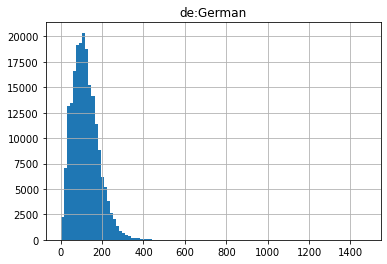

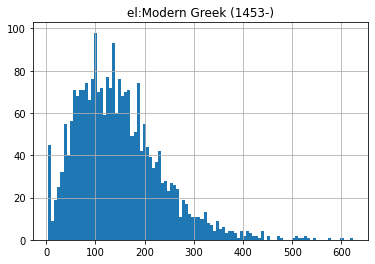

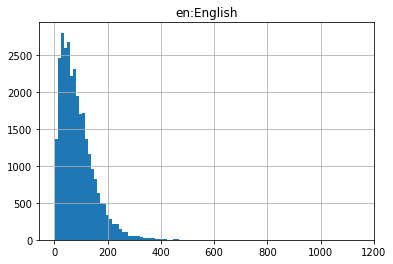

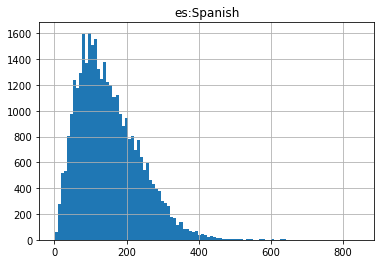

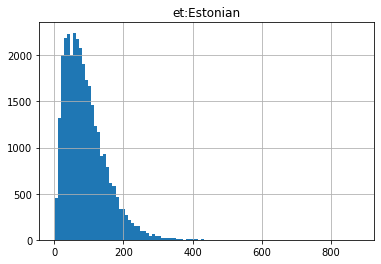

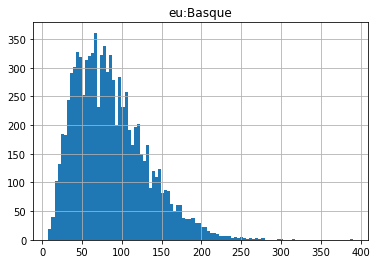

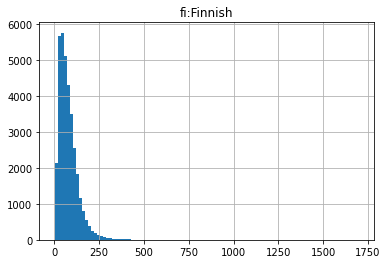

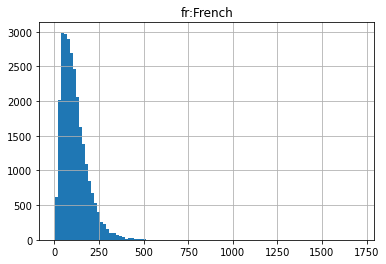

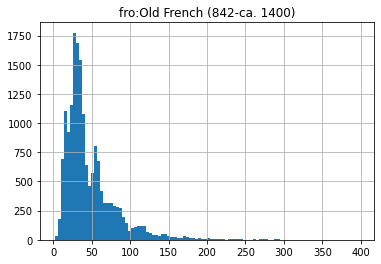

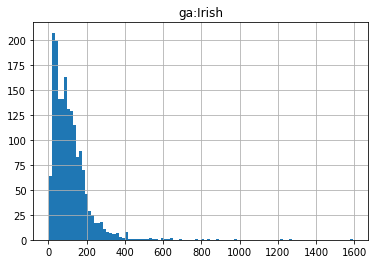

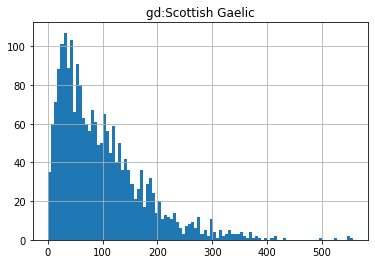

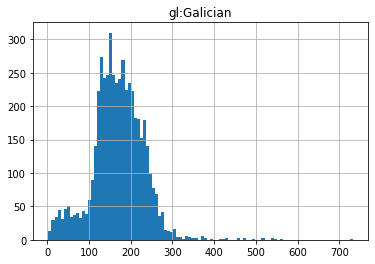

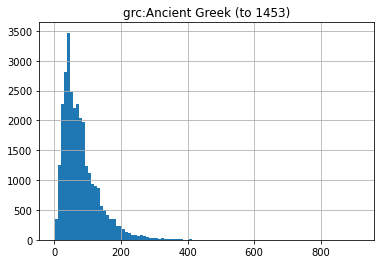

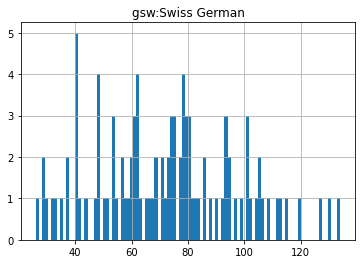

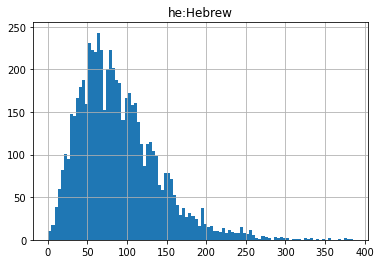

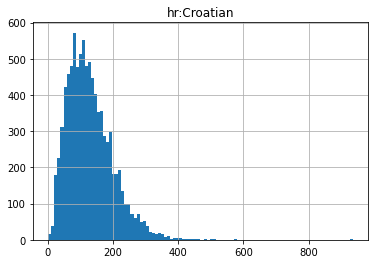

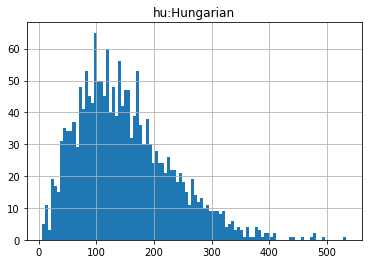

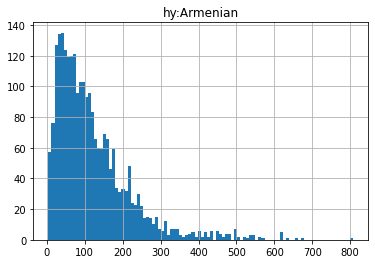

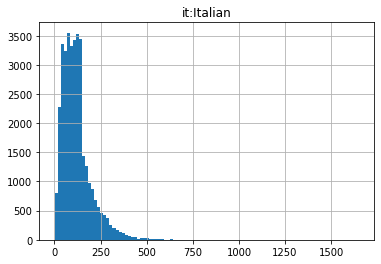

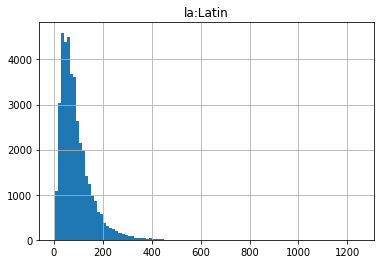

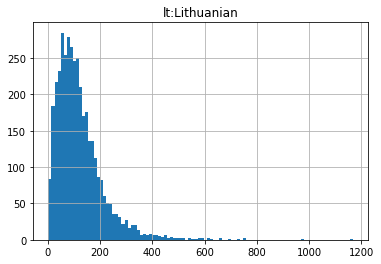

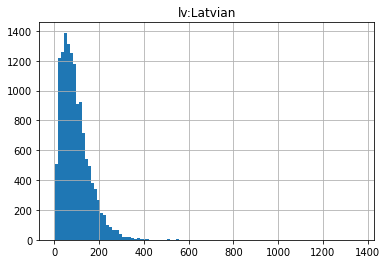

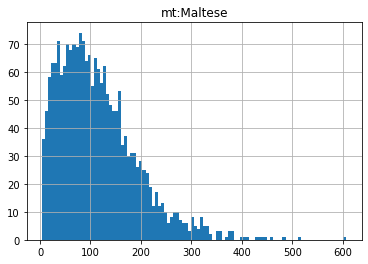

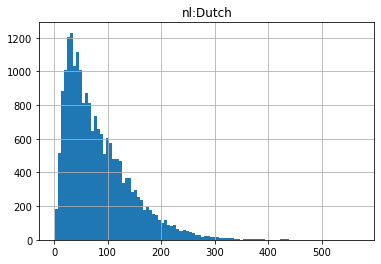

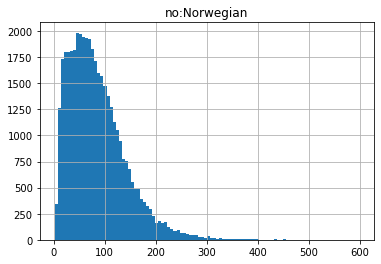

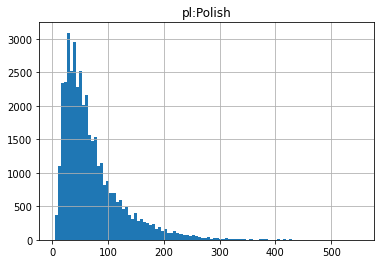

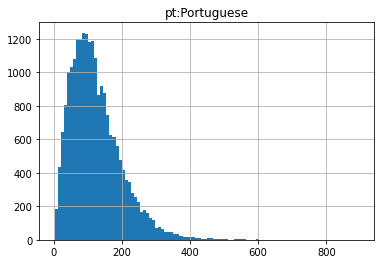

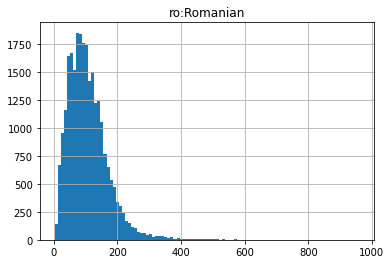

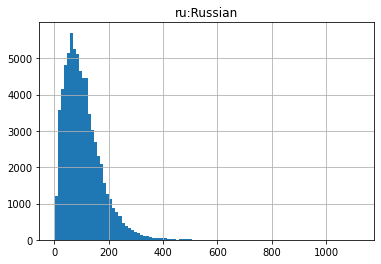

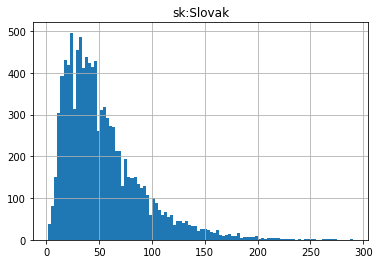

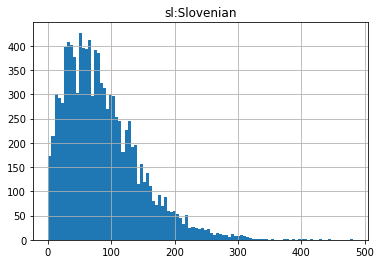

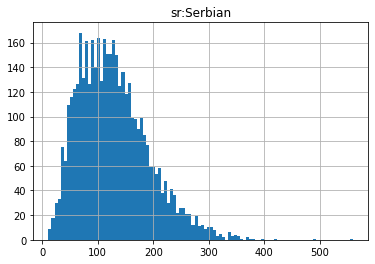

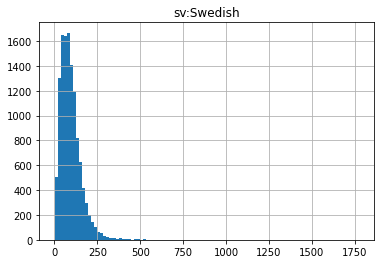

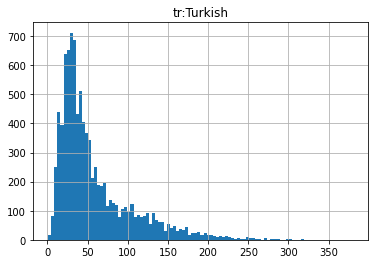

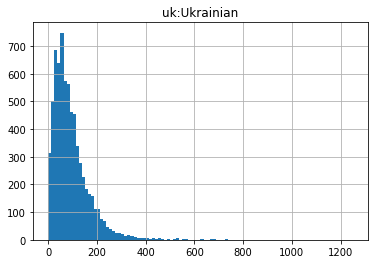

In [58]:
for lang in langs:
    fig, ax = plt.subplots()
    dest_lang = languages.get(alpha_2=lang) if len(lang) == 2 else languages.get(alpha_3=lang)
    dest_lang = dest_lang.name
    ax.set_title(lang +":" +dest_lang )
    df_txt.loc[df_txt['lang'] == lang]['text_len'].hist(bins=100, ax=ax, label=lang)

In [59]:
MAYBE_BLACKLIST_LANGS = ['ceb', 'jv', 'ce', 'cv', 'dv', 'ht', 'hy', 'ku', 'mh', 'mi', 'ps', 'su', 'tk', 'ba', 'tg',
                         'tt', 'ug'
                         ]
# blacklisting due to lack of samples, extinct language or other issue
EXTRA_BLACKLIST = ["olo", "swl", "bxr", "fa", "sme", "aii", "gun", "yo", "akk", "fo", "mdf",
                   "krl", "pcm", "bho", "sms", "am", "bm", "got", "cu", "hsb", "wo",
                  ]

# blacklists to reduce even more the number of languages, latin is left because will be used FIRST to train to set a learning baseline ...
# base, greek, old french and ancient greek will be nice too if I manage to transliterate it
# extra blacklisting to reduce the number of alphabets used and other low resource and other non-official languages
MORE_EXTRA_BLACKLIST = ["af", "gsw", "he", 
                        "ca", "cy", "eu", "ga", "gd", "gl", "cr", "hy", "tr",
                       ]

ANCIENT_LANGS = ["la", "grc", "fro",]  # latin, ancient greek, old french -> base for MANY languages
GREEK_BLACKLIST = ["el", "grc"]

# this means mainly taking out cyrillic scripts ... but bulgarian IS in the EU and uses 
# cyrillic so ... there it is, won't take them out
CYRILLIC_BLACKLIST = ["be", "bg", "he", "ru", "sr", "uk"]


BLACKLIST_LANGS = ['ar', 'as', 'arz', 'azb', 'bn', 'bp', 'ckb', 'eo', 'ew', 'fa', 'fo', 'gom', 'gu', 'hi', 'hu', 'id',
                   'ilo', 'ja', 'ka', 'kk', 'ko', 'lmo', 'ml', 'mr', 'mwl', 'ne', 'pa', 'py', 'sh', 'si', 'ta', 'te',
                   'th', 'tl', 'ur', 'vi',
                   'wuu', 'yi', 'zb', 'zh'
                   ] + MAYBE_BLACKLIST_LANGS + EXTRA_BLACKLIST

BLACKLIST_LANGS = sorted(list(set(BLACKLIST_LANGS)))

len(BLACKLIST_LANGS)

76

In [60]:
len(langs)

42

In [61]:
langs

['af',
 'be',
 'bg',
 'ca',
 'cs',
 'cy',
 'da',
 'de',
 'el',
 'en',
 'es',
 'et',
 'eu',
 'fi',
 'fr',
 'fro',
 'ga',
 'gd',
 'gl',
 'grc',
 'gsw',
 'he',
 'hr',
 'hu',
 'hy',
 'it',
 'la',
 'lt',
 'lv',
 'mt',
 'nl',
 'no',
 'pl',
 'pt',
 'ro',
 'ru',
 'sk',
 'sl',
 'sr',
 'sv',
 'tr',
 'uk']

From the results, sample count and some other observations, I'm now cutting more languages (the EXTRA_BLACKLIST) such as to cut the complexity of the training dataset while trying to keep as much as possible to make a multi lingual 

In [62]:
# convert 2 letter code to 3 letter ISO 639-3

from pycountry import languages



In [63]:
pclangs = []

for l in langs:
    pclangs.append(languages.get(alpha_2=l))

In [64]:
pclangs

[Language(alpha_2='af', alpha_3='afr', name='Afrikaans', scope='I', type='L'),
 Language(alpha_2='be', alpha_3='bel', name='Belarusian', scope='I', type='L'),
 Language(alpha_2='bg', alpha_3='bul', name='Bulgarian', scope='I', type='L'),
 Language(alpha_2='ca', alpha_3='cat', name='Catalan', scope='I', type='L'),
 Language(alpha_2='cs', alpha_3='ces', bibliographic='cze', name='Czech', scope='I', type='L'),
 Language(alpha_2='cy', alpha_3='cym', bibliographic='wel', name='Welsh', scope='I', type='L'),
 Language(alpha_2='da', alpha_3='dan', name='Danish', scope='I', type='L'),
 Language(alpha_2='de', alpha_3='deu', bibliographic='ger', name='German', scope='I', type='L'),
 Language(alpha_2='el', alpha_3='ell', bibliographic='gre', inverted_name='Greek, Modern (1453-)', name='Modern Greek (1453-)', scope='I', type='L'),
 Language(alpha_2='en', alpha_3='eng', name='English', scope='I', type='L'),
 Language(alpha_2='es', alpha_3='spa', name='Spanish', scope='I', type='L'),
 Language(alpha_

In [67]:
langs_3code = [l.alpha_3 for l in pclangs if l]


In [68]:
langs_3code

['afr',
 'bel',
 'bul',
 'cat',
 'ces',
 'cym',
 'dan',
 'deu',
 'ell',
 'eng',
 'spa',
 'est',
 'eus',
 'fin',
 'fra',
 'gle',
 'gla',
 'glg',
 'heb',
 'hrv',
 'hun',
 'hye',
 'ita',
 'lat',
 'lit',
 'lav',
 'mlt',
 'nld',
 'nor',
 'pol',
 'por',
 'ron',
 'rus',
 'slk',
 'slv',
 'srp',
 'swe',
 'tur',
 'ukr']

In [63]:
# @interact
# def show_len_by_lang(column='upos_len', x=10):
# #     return df_upos[df_upos[column == x]]  # ['upos_len'].hist(bins=100, log=True)
#     return df_upos.loc[df_upos[column] > x]

In [64]:
df_deprel['deprel'].head(n=10)

0    (nsubj, det, amod, nmod, root, cop, punct, obl...
1    (obl, case, punct, nsubj, root, aux, punct, cc...
2                (nsubj, obl, advcl, root, aux, punct)
3    (nsubj, nummod, obj, root, obj, advcl, advmod,...
4    (advmod, obj, amod, root, aux, punct, nsubj, x...
5    (cc, advmod, nsubj, advmod, advmod, cc, conj, ...
6    (nsubj, advmod, advmod, root, aux, punct, obl,...
7    (obl, punct, nmod, nsubj, cop, root, punct, ns...
8    (obl, det, case, nmod, nsubj, det, root, aux, ...
9    (nmod, nmod, punct, appos, punct, det, nmod, n...
Name: deprel, dtype: object

In [65]:
# train[0]

In [66]:
# %%time

# all_upos = set([])
# all_upos_count = 0
# all_deprel = set([])
# all_deprel_count = 0

# for r in res:
#     (upos, upos_count), (xpos, xpos_count), (deprel, deprel_count) = r
#     all_upos = all_upos.union(upos)
#     all_upos_count += upos_count
#     all_deprel = all_deprel.union(deprel)
#     all_deprel_count += deprel_count
    



In [68]:
# len(all_upos), all_upos_count, len(all_deprel), all_deprel_count

It seems kind of big for putting it directly in a memory, some compression should be done if this method is to work ... (it should be more data efficient than the current methods)

For a single language that might be feasible, but as more languages are added this leads to a volume problem ... 

In [69]:
lall_upos = list(all_upos)
lup = [len(u) for u in lall_upos]

NameError: name 'all_upos' is not defined

In [70]:
max(lup), min(lup)

NameError: name 'lup' is not defined

In [71]:
lup.index(max(lup)), lup.index(min(lup))

NameError: name 'lup' is not defined

In [72]:
lall_upos[83026]

NameError: name 'lall_upos' is not defined

In [73]:
lall_upos[371226]

NameError: name 'lall_upos' is not defined

The issue here seems to be the length of the sentences, putting a max length might work but will leave longer sentences out of the training.

The other idea would be to use a more thourough diccionary that contains more elements this will make smaller sentences, this means, for the training set the max length is 515 words, this is still too much.

The counterpoint when using a bigger dictionary is that even if the length of the input is smaller, the bigger the dictionary  the bigger the memory impact for the encoding and decoding.




In [75]:
# now I should get all the words and check the number and length there are

len(forms_data)

2857622